In [17]:
import numpy as np
from astropy.timeseries import LombScargle
from constants import DATA_DIR
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from astrofit.model import Asteroid, Lightcurve, LightcurveBin
from astrofit.utils import (
    AsteroidLoader,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)

In [2]:
TOP_K_BINS = 3
TOP_K_FREQS = 100

In [3]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()

In [4]:
eros = asteroid_loader.load_asteroid("Eros")
eros

Asteroid(id=433, name=Eros, period=5.27025528, lightcurves=118)

In [5]:
splitted_lightcurves = lightcurve_splitter.split_lightcurves(
    eros.lightcurves,
    max_hours_diff=1,
    min_no_points=5,
)

In [6]:
bins = lightcurve_binner.bin_lightcurves(splitted_lightcurves, max_time_diff=30, min_bin_size=5)
bins

[LightcurveBin(lightcurves=13, period=19.16246h),
 LightcurveBin(lightcurves=16, period=25.15529h),
 LightcurveBin(lightcurves=29, period=20.10417h),
 LightcurveBin(lightcurves=21, period=18.06383h),
 LightcurveBin(lightcurves=6, period=6.15218h),
 LightcurveBin(lightcurves=7, period=3.13984h),
 LightcurveBin(lightcurves=27, period=23.24818h),
 LightcurveBin(lightcurves=66, period=29.57093h),
 LightcurveBin(lightcurves=70, period=30.03412h),
 LightcurveBin(lightcurves=86, period=28.00537h),
 LightcurveBin(lightcurves=34, period=28.12255h),
 LightcurveBin(lightcurves=8, period=28.99570h),
 LightcurveBin(lightcurves=6, period=23.10062h),
 LightcurveBin(lightcurves=6, period=16.88805h),
 LightcurveBin(lightcurves=16, period=26.12364h),
 LightcurveBin(lightcurves=14, period=29.98341h),
 LightcurveBin(lightcurves=5, period=30.03488h)]

In [7]:
top_k = sorted(bins, reverse=True)[:TOP_K_BINS]
top_k

[LightcurveBin(lightcurves=86, period=28.00537h),
 LightcurveBin(lightcurves=70, period=30.03412h),
 LightcurveBin(lightcurves=66, period=29.57093h)]

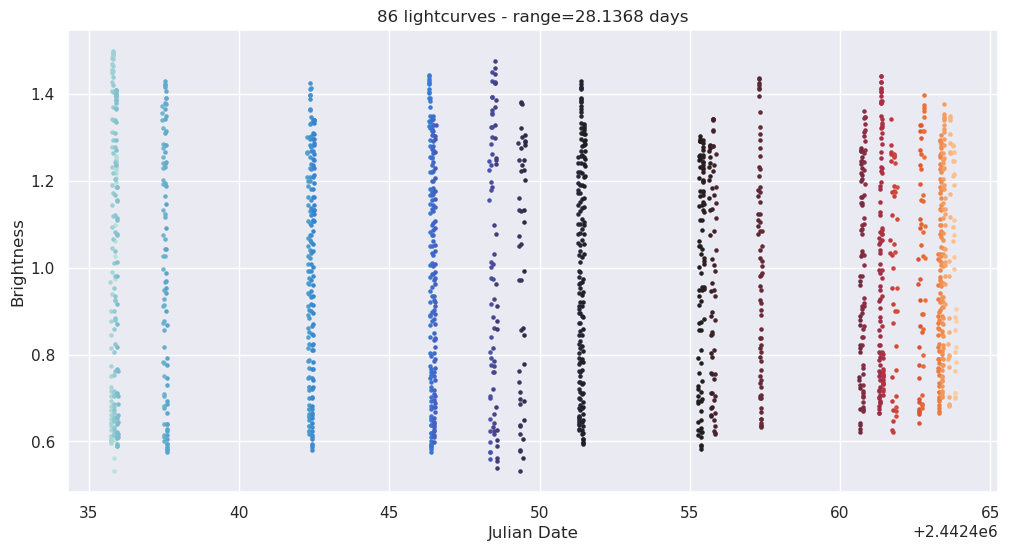

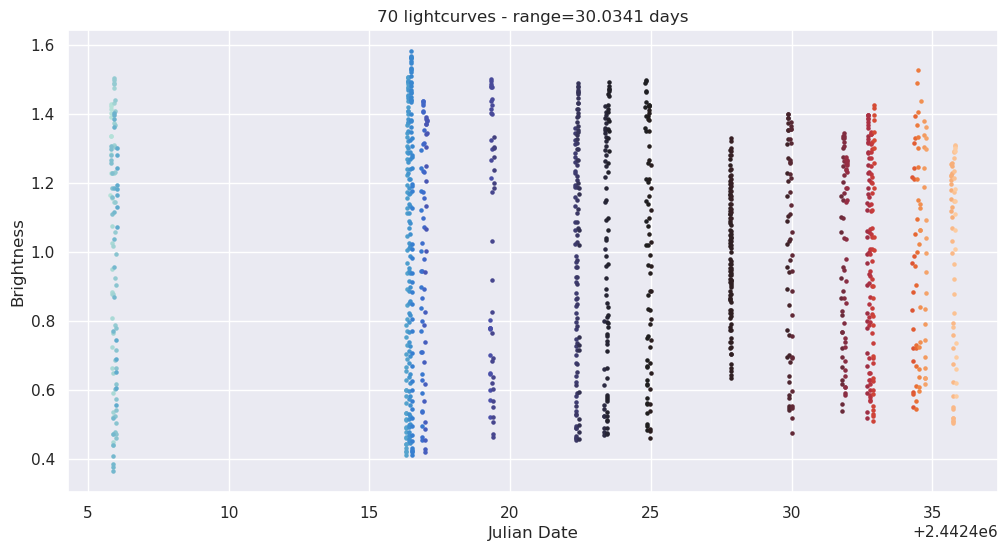

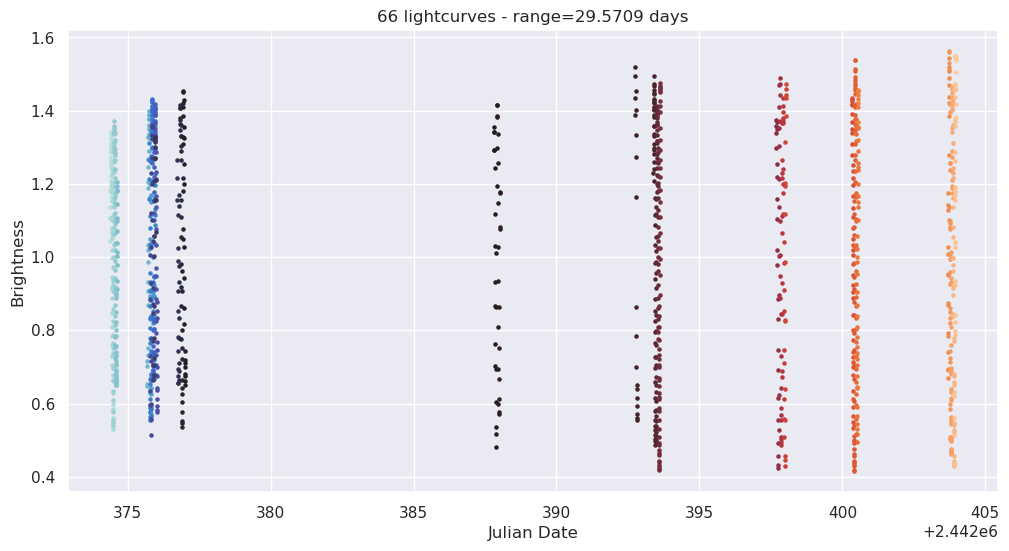

In [8]:
for _bin in top_k:
    lightcurve_plotter.plot_lightcurves(_bin)

In [9]:
def _split_lightcurves(asteroid: Asteroid) -> list[Lightcurve]:
    return lightcurve_splitter.split_lightcurves(
        asteroid.lightcurves,
        max_hours_diff=1,
        min_no_points=5,
    )


def _get_top_k_bins(lightcurves: list[Lightcurve], top_k: int = TOP_K_BINS) -> list[LightcurveBin]:
    bins = lightcurve_binner.bin_lightcurves(lightcurves, max_time_diff=30, min_bin_size=5)

    return sorted(bins, reverse=True)[:top_k]


def _get_top_k_freqs(lightcurve_bin: LightcurveBin, top_k: int = TOP_K_FREQS):
    frequency, power = LombScargle(lightcurve_bin.times, lightcurve_bin.brightnesses, nterms=3).autopower()

    top_k_freqs = frequency[np.argsort(power)[-top_k:]]
    top_k_periods = 24 / top_k_freqs

    return np.sort(top_k_periods)


def get_freq_features(asteroid: Asteroid) -> np.ndarray | None:
    splitted_lightcurves = _split_lightcurves(asteroid)
    top_k_bins = _get_top_k_bins(splitted_lightcurves, top_k=TOP_K_BINS)

    if not top_k_bins or len(top_k_bins) < TOP_K_BINS:
        return

    freq_features = []
    for _bin in top_k_bins:
        top_k_freqs = _get_top_k_freqs(_bin, top_k=TOP_K_FREQS)
        freq_features.extend(top_k_freqs)

    return np.array(freq_features)

In [10]:
train_asteroids: list[Asteroid] = []
for key in asteroid_loader.available_asteroids:
    if key in ("Interamnia", "Eros"):
        continue

    asteroid = asteroid_loader.load_asteroid(key)
    if len(asteroid.lightcurves) < 10:
        continue

    train_asteroids.append(asteroid)


print(f"Train asteroids: {len(train_asteroids)}")

Train asteroids: 77


In [11]:
test_asteroids: list[Asteroid] = []
for key in ["Eros", "Interamnia"]:
    asteroid = asteroid_loader.load_asteroid(key)
    test_asteroids.append(asteroid)


print(f"Test asteroids: {len(test_asteroids)}")

Test asteroids: 2


In [12]:
cnt = len(train_asteroids)

train_X = []
train_y = []
for ind, asteroid in enumerate(train_asteroids):
    print(f"\r{ind + 1:2} / {cnt:2}", end="")

    freq_features = get_freq_features(asteroid)
    if freq_features is None:
        print(f"\nWARNING: Could not set freq features for {asteroid.name}")
        continue

    train_X.append(freq_features)
    train_y.append(asteroid.period)

train_X = np.vstack(train_X)
train_y = np.array(train_y)

 2 / 77
 4 / 77
12 / 77
16 / 77
34 / 77
47 / 77
52 / 77
74 / 77
77 / 77

In [13]:
cnt = len(test_asteroids)

test_X = []
test_y = []
for ind, asteroid in enumerate(test_asteroids):
    print(f"\r{ind + 1:2} / {cnt:2}", end="")

    freq_features = get_freq_features(asteroid)
    if freq_features is None:
        print(f"\nWARNING: Could not set freq features for {asteroid.name}")
        continue

    test_X.append(freq_features)
    test_y.append(asteroid.period)

test_X = np.vstack(test_X)
test_y = np.array(test_y)

 2 /  2

In [29]:
regressor = XGBRegressor(
    n_estimators=10000,
    max_depth=10,
    learning_rate=0.01,
    n_jobs=-1,
    eval_metric=mean_squared_error,
)
regressor.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7f1b7b3b4360>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [30]:
pred_y = regressor.predict(test_X)
pred_y


array([5.671949, 9.600279], dtype=float32)

In [31]:
[asteroid.period for asteroid in test_asteroids]

[5.27025528, 8.712337]